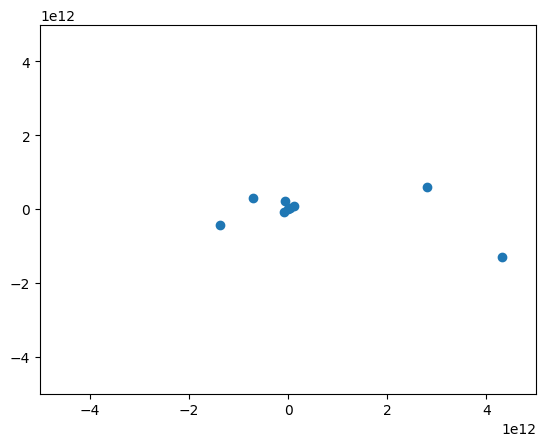

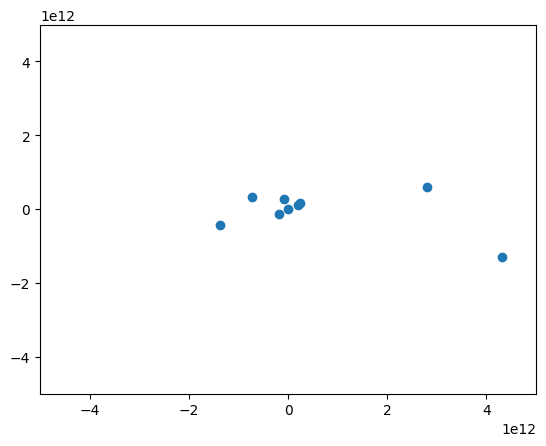

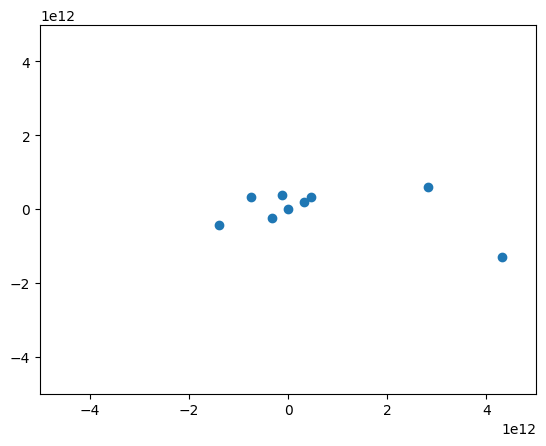

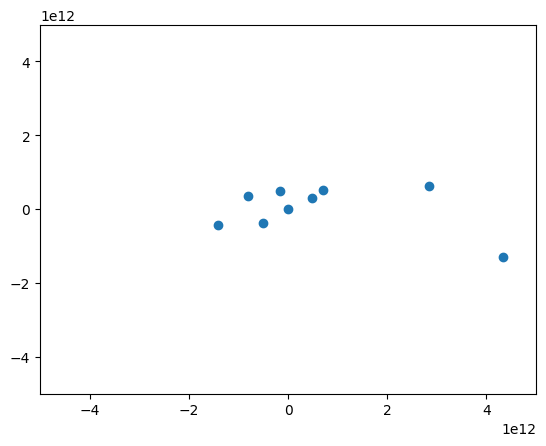

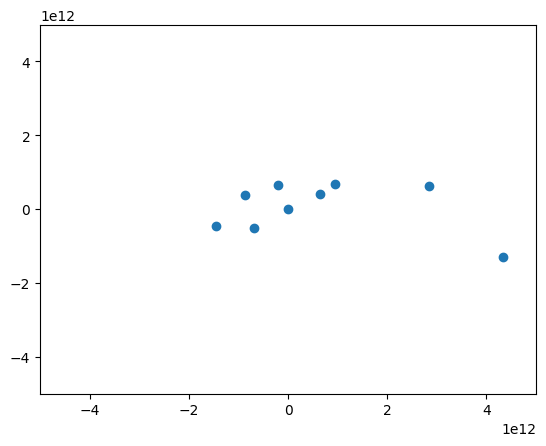

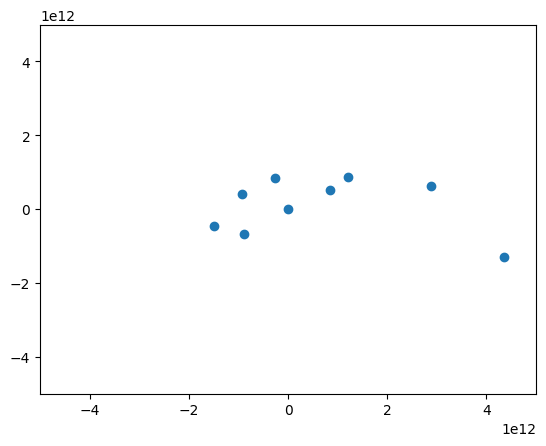

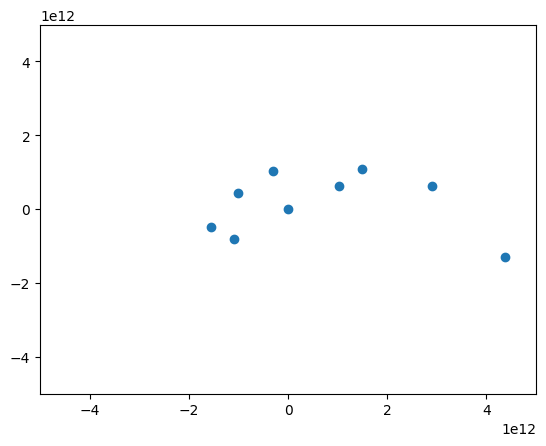

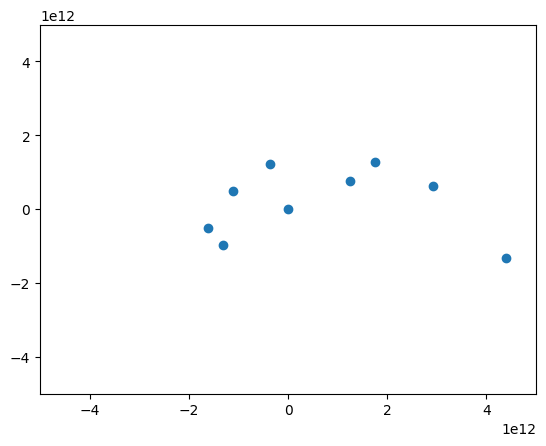

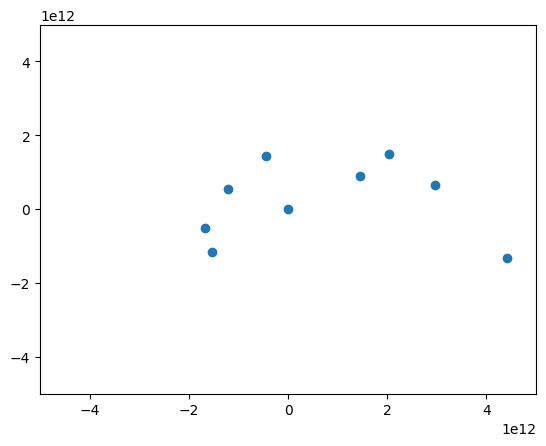

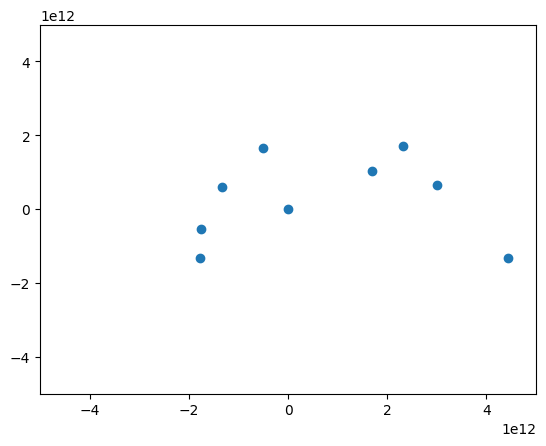

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import math
import json

G = 6.6743e-11


class Planet:
    def __init__(self, mass: int, position_array: float, velocity_array: float):
        self.mass = mass
        self.position = np.array(position_array)
        self.velocity = np.array(velocity_array)

"""
def calculate_force(planetA: Planet,planetB: Planet):
    r = np.linalg.norm(planetA.position - planetB.position)

    F = G*((planetA.mass*planetB.mass)/(r*r))

    return 
"""

def calculate_all_distances(planets: list[Planet]):

    distances: list[list[float]] = [[0 for _ in range(len(planets))] 
                                        for _ in range(len(planets))]
    for i in range(len(planets)):
        for j in range(i+1,len(planets)):
            dist = np.linalg.norm(planets[i].position - planets[j].position)

            distances[i][j] = dist
            distances[j][i] = dist

    return distances

def calculate_all_forces(planets: list[Planet]):
    distances = calculate_all_distances(planets)

    forces: list[list[np.array]] = [[0 for _ in range(len(planets))] 
                                        for _ in range(len(planets))]
    

    for i in range(len(planets)):
        for j in range(i+1, len(planets)):
            force = G*((planets[i].mass*planets[j].mass)/(distances[i][j]))           
            force_vector = force * (planets[j].position-planets[i].position)/(distances[i][j])

            forces[i][j] = force_vector
            forces[j][i] = force_vector

    return forces

def calculate_all_accelerations(planets: list[Planet]):
    accels: list[np.array] = [0 for _ in range(len(planets))] 
    forces = calculate_all_forces(planets)                                    
    
    for i in range(len(planets)):
        force = np.sum(forces[i])

        accels[i] = force/planets[i].mass

    return accels

def move_planets(planets: list[Planet],time_interval):
    accels = calculate_all_accelerations(planets)

    for i in range(len(planets)):
        planets[i].velocity += accels[i]*time_interval
        planets[i].position += planets[i].velocity*time_interval

def load_from_json(filename: str):
    f = open('test1.json')

    json_dict = json.load(f)

    planets = []
    for value in json_dict.values():
        planets.append(Planet(value['mass'], value['position'], value['velocity']))

    f.close()

    return planets

def draw(planets: list[Planet],size):

    fig, axes = plt.subplots()
    xpoints = [p.position[0] for p in planets]
    ypoints = [p.position[1] for p in planets]
    
    axes.plot(xpoints,ypoints, 'o')
    axes.set_xlim([-size,size])
    axes.set_ylim([-size,size])

planets = load_from_json('test1.json')



def animate(planets: list[Planet], size, duration, time_interval):
    
    for i in range(int(duration / time_interval)):
        draw(planets, size)
        move_planets(planets,time_interval)

animate(planets, 5e12, 100, 10)